In [1]:
# Import necessary libraries for data handling, analysis, and visualization
import yfinance as yf          # For downloading historical stock/index data
import pandas as pd            # For data manipulation and analysis
import numpy as np             # For numerical operations
import warnings                # To manage warning messages
import matplotlib.pyplot as plt # For plotting and visualizations
import statsmodels.api as sm   # To perform statistical analysis (e.g., OLS regression)

# Suppress warning messages to keep the output clean
warnings.filterwarnings("ignore")

In [2]:

#Set the list of stocks and indices to be downloaded
stocks = ['RACE', 'TSLA', 'JNJ', 'XOM']
market_ticker = "^GSPC"
rf_ticker = "^IRX"

# Set the start and end dates for data download
start_date = "2015-01-02"
end_date = "2025-01-02"

# Combine stock tickers with the market and risk-free rate tickers
tickers = stocks + [market_ticker, rf_ticker]

# Download daily "Close" price data for all tickers from Yahoo Finance
data_daily = yf.download(tickers, start=start_date, end=end_date, progress=False)['Close']

# Resample daily data to weekly frequency using the last observed value of each week
weekly_data = data_daily.resample('W').last()

# Drop rows with missing values in key columns (benchmark and risk free rate) to ensure data quality
weekly_data.dropna(subset=[rf_ticker, market_ticker], inplace=True)

# Display the first and last five rows of the weekly data to verify the results
print(weekly_data.head())
print(weekly_data.tail())

YF.download() has changed argument auto_adjust default to True
Ticker            JNJ  RACE       TSLA        XOM        ^GSPC   ^IRX
Date                                                                 
2015-01-04  78.681412   NaN  14.620667  59.510242  2058.199951  0.015
2015-01-11  78.997589   NaN  13.777333  59.042244  2044.810059  0.015
2015-01-18  78.320068   NaN  12.871333  58.414001  2019.420044  0.018
2015-01-25  76.934944   NaN  13.419333  58.266541  2051.820068  0.013
2015-02-01  75.384163   NaN  13.573333  56.042065  1994.989990  0.005
Ticker             JNJ        RACE        TSLA         XOM        ^GSPC   ^IRX
Date                                                                          
2024-12-08  148.124313  458.440002  389.220001  112.563156  6090.270020  4.295
2024-12-15  145.455673  454.179993  436.230011  109.857353  6051.089844  4.218
2024-12-22  143.322754  426.929993  421.059998  104.931419  5930.850098  4.215
2024-12-29  143.898148  432.149994  431.660004  105.

In [3]:
#Compute Weekly Returns and Excess Returns
returns = weekly_data.pct_change().dropna()

# *** FIX: Reindex the risk-free rate to match the returns index ***
rf_series = weekly_data[rf_ticker].reindex(returns.index)

#Forward fill the missing values
rf_series.fillna(method='ffill', inplace=True)

#For risk free rate:
#^IRX is usually quoted as an annual yield percentage terms 
#Convert the annual rate to a weekly rate by dividing by 100 and then by 52
returns['rf'] = rf_series / 100 / 52

#Compute Excess Returns
excess_returns ={}
for ticker in stocks:
    excess_returns[ticker] = returns[ticker] - returns['rf']

#Compute Market Excess Returns
market_excess = returns[market_ticker] - returns['rf']

In [4]:
print("CAPM Regression Results (Full 10 Year Sample) === \n") 
capm_results = {}  # Store the results in a dictionary

for ticker in stocks:
    # Dependent Variable: Stock Excess Returns
    y = excess_returns[ticker]
    # Independent Variable: Market Excess Returns (with constant added)
    X = sm.add_constant(market_excess)
    # Rename columns so that the market excess returns column has a clear name
    X.columns = ['const', 'market_excess']
    # Combine y and X, and drop rows with NaN or infinite values
    df = pd.concat([y, X], axis=1)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Check if the resulting DataFrame is empty
    if df.empty:
        print(f"No valid data available for {ticker} after cleaning. Skipping regression for this ticker.\n")
        continue
    
    # Extract cleaned y and X (assumes y is the first column in the combined DataFrame)
    y_clean = df.iloc[:, 0]
    X_clean = df.iloc[:, 1:]
    # Run the regression on the cleaned data
    model = sm.OLS(y_clean, X_clean).fit()
    capm_results[ticker] = model
    
    print(f"CAPM Regression Results for {ticker} === \n")
    print(model.summary())
    print("\n")

    betas = {ticker: capm_results[ticker].params['market_excess'] for ticker in capm_results.keys()}
if capm_results:
    betas = {ticker: capm_results[ticker].params[1] for ticker in capm_results.keys()}
    print("Estimated Betas === \n")
    for ticker, beta in betas.items():
        print(f"{ticker}: {beta:.4f}")

    most_sensitive = max(betas, key=betas.get)
    least_sensitive = min(betas, key=betas.get)

    print(f"\nMost Sensitive Stock to market changes (highest beta): {most_sensitive} (Beta = {betas[most_sensitive]:.4f})")
    print(f"Least Sensitive Stock to market changes (lowest beta): {least_sensitive} (Beta = {betas[least_sensitive]:.4f})")
else:
    print("No regressions were run due to insufficient valid data.")

CAPM Regression Results (Full 10 Year Sample) === 

CAPM Regression Results for RACE === 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     200.7
Date:                Mon, 03 Mar 2025   Prob (F-statistic):           2.77e-38
Time:                        18:17:32   Log-Likelihood:                 954.44
No. Observations:                 480   AIC:                            -1905.
Df Residuals:                     478   BIC:                            -1897.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

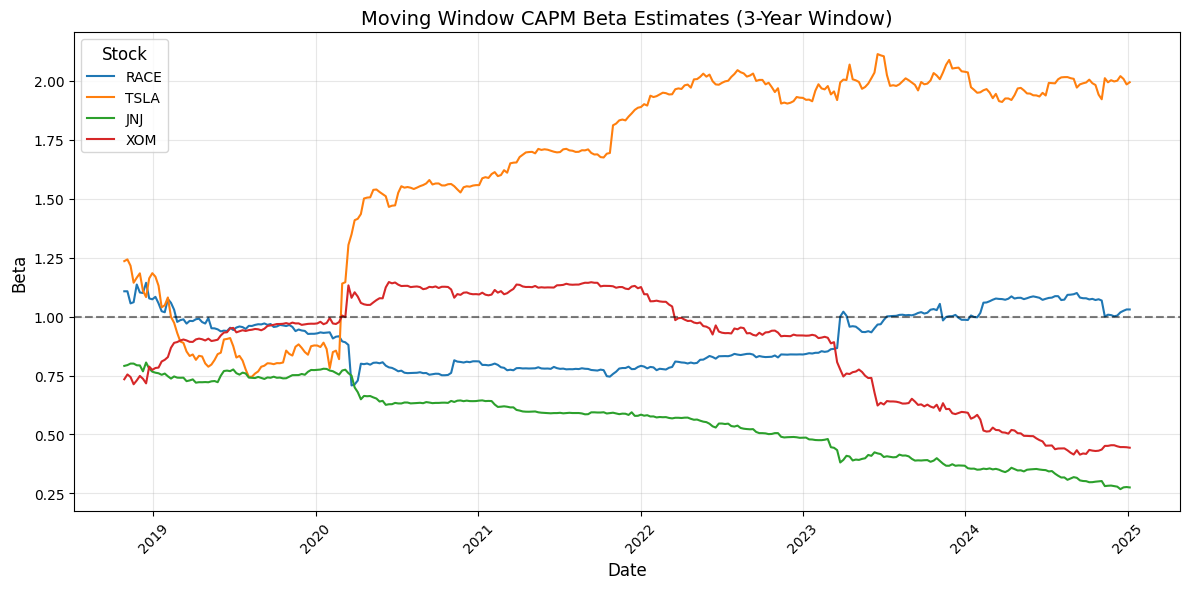

In [6]:

import pandas as pd

# 5. Moving Window Regressions (3-Year Window)
# -------------------------------

window_size = 157
moving_betas = {ticker: [] for ticker in stocks}
window_dates = []

for i in range(0, len(returns) - window_size + 1):
    window_data = returns.iloc[i : i + window_size]
    market_excess_window = window_data[market_ticker] - window_data['rf']
    window_dates.append(window_data.index[-1])
    
    for ticker in stocks:
        y_window = window_data[ticker] - window_data['rf']
        X_window = sm.add_constant(market_excess_window)
        X_window.columns = ['const', 'market_excess']
        model_window = sm.OLS(y_window, X_window).fit()
        moving_betas[ticker].append(model_window.params['market_excess'])

# Prepare a DataFrame for plotting
df_betas = pd.DataFrame(moving_betas)
df_betas['Date'] = window_dates

# Set the Date as index for easier plotting with Seaborn
df_betas.set_index('Date', inplace=True)

# Create a figure with appropriate size
plt.figure(figsize=(12, 6))

# Plot the moving betas using Seaborn
for ticker in stocks:
    plt.plot(df_betas.index, df_betas[ticker], label=ticker)

# Add title and labels
plt.title('Moving Window CAPM Beta Estimates (3-Year Window)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Beta', fontsize=12)
plt.legend(title='Stock', title_fontsize=12)
plt.grid(True, alpha=0.3)

# Format the x-axis to show dates clearly
plt.xticks(rotation=45)
plt.tight_layout()

# Add horizontal line at beta = 1 for reference
plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Beta = 1')

# Show the plot
plt.show()